In [1]:
import pandas as pd
import numpy as numpy
import matplotlib.pyplot as plt
from helper import *
import itertools

In [2]:
from sklearn import  model_selection
from sklearn.model_selection import cross_validate, cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

In [3]:
plt.style.use('seaborn')

### 1. Import dataset

In [4]:
df = pd.read_csv('UCI_Credit_Card.csv')
X_1, X_2, y_1, y_2 = train_test_split(df.loc[:, df.columns != 'default.payment.next.month'], 
                                      df['default.payment.next.month'], 
                                      test_size= 4000, 
                                      train_size = 6000, random_state = 42)
X_1, X_v, y_1, y_v = train_test_split(X_1,y_1, test_size=2000, random_state = 42)

d1_keep_list = df.columns[1:12]
X_1 = X_1[d1_keep_list]

d2_keep_list = df.columns[12:-1]
X_2 = X_2[d2_keep_list]

X1_train, X1_test, y1_train, y1_test = train_test_split(X_1, y_1, train_size=0.8, random_state = 42)

X2_train, X2_test, y2_train, y2_test = train_test_split(X_2, y_2, train_size=0.8, random_state = 42)

### Standardize the Variables

In [5]:
scaler = StandardScaler()

In [6]:
df_lst = [[X1_train, X1_test], [X2_train, X2_test]]
suffix = ['train_s', 'test_s']
df_scaled = dict()

for i in range(1, 3):
    scaler.fit(pd.concat(df_lst[i - 1], axis = 0))
    for index, j in enumerate(df_lst[i - 1]):
        df_scaled['X' + str(i) + '_' + suffix[index]] = pd.DataFrame(scaler.transform(j), 
                                                                    columns = j.columns)
df_scaled['X1_train_s']

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,-0.680604,-1.231147,0.177457,-1.076134,-0.258547,0.022933,0.115828,0.163863,0.184417,0.239999,0.254224
1,-1.228285,-1.231147,1.445007,0.851558,0.608607,0.022933,0.115828,-1.534195,-1.523149,-0.647243,-0.614177
2,-1.071805,0.812251,1.445007,-1.076134,-0.692124,0.922285,1.791457,1.861920,1.891984,2.014481,1.991027
3,-0.132922,0.812251,0.177457,0.851558,-0.692124,0.022933,0.115828,0.163863,0.184417,0.239999,0.254224
4,-0.211162,0.812251,0.177457,0.851558,-1.342490,0.022933,0.115828,0.163863,0.184417,0.239999,0.254224
...,...,...,...,...,...,...,...,...,...,...,...
3195,-1.071805,0.812251,0.177457,0.851558,-1.342490,0.022933,0.115828,0.163863,0.184417,0.239999,1.991027
3196,0.962441,0.812251,-1.090093,0.851558,1.150578,0.022933,0.115828,-0.685166,-0.669366,-0.647243,-0.614177
3197,0.336519,0.812251,-1.090093,-1.076134,0.825395,-1.775769,-0.721987,-0.685166,-0.669366,-1.534484,-1.482578
3198,-1.150045,0.812251,-1.090093,0.851558,-1.125702,-0.876418,0.115828,0.163863,1.891984,0.239999,0.254224


## Algorithm 4: KNN



### Choosing a K Value by Grid Searching

In [7]:
def KNNgridSearchCV(X_train, Y_train, X_test, Y_test, title, save_name,
                   k_range = range(1, 40), plot = True):
    
    import multiprocessing

    cores = multiprocessing.cpu_count()
    
    if plot:
        f1_cv, f1_train, f1_test = list(), list(), list()
        
        kfold = model_selection.KFold(n_splits=5, random_state=42, shuffle=True)       
        
        for i in k_range:
            knn = KNeighborsClassifier(n_neighbors = i, n_jobs = cores - 2)
            knn.fit(X_train, Y_train)
            y_pred_train = knn.predict(X_train)
            y_pred_test = knn.predict(X_test)
            cv_results = cross_val_score(estimator = knn, 
                                        X = X_train,
                                        y = Y_train,
                                        cv = kfold,
                                        scoring = 'f1',
                                        n_jobs = cores - 1)
            f1_cv.append(cv_results.mean())
            f1_train.append(f1_score(Y_train, y_pred_train))
            f1_test.append(f1_score(Y_test, y_pred_test))
        
        plt.plot(k_range, f1_cv, 'o-', color='r', label='CV F1 Score')
        plt.plot(k_range, f1_train, 'o-', color = 'b', label='Train F1 Score')
        plt.plot(k_range, f1_test, 'o-', color = 'g', label = 'Test F1 Score')
        plt.ylabel('Model F1 Score')
        plt.xlabel('K Value')

        plt.title(title)
        plt.legend(loc='best')
        plt.tight_layout()
        plt.savefig(save_name)
        plt.show()
    
    param_grid = {'n_neighbors' : np.array(k_range),
                  'weights' : ['uniform', 'distance'],
                 'p' : [1, 2]}
    knn = GridSearchCV(estimator = KNeighborsClassifier(),
                      param_grid = param_grid, cv = 10, refit = True,
                      scoring = 'f1', n_jobs = cores - 1)
    knn.fit(X_train, Y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(knn.best_params_)
    print(knn.best_score_)
    return knn.best_params_

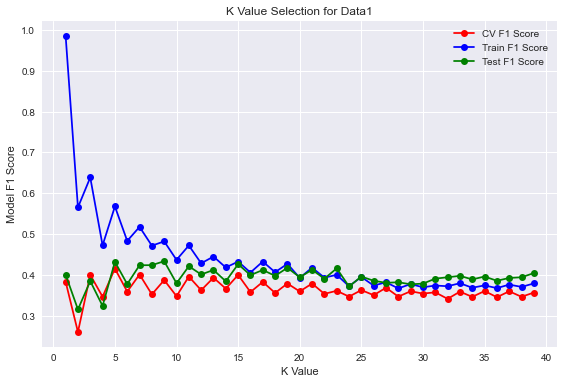

Per Hyperparameter tuning, best parameters are:
{'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}
0.42656660351654774


In [8]:
# data 1
best_param_1 = KNNgridSearchCV(df_scaled['X1_train_s'], y1_train, 
                df_scaled['X1_test_s'], y1_test, 
                'K Value Selection for Data1', 'd1_k_value_selection.png', 
                k_range = range(1, 40), plot = True)

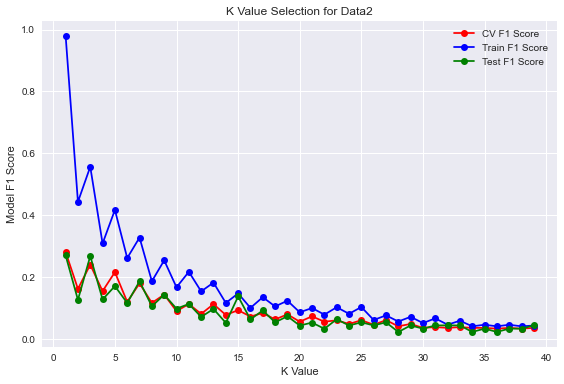

Per Hyperparameter tuning, best parameters are:
{'n_neighbors': 1, 'p': 1, 'weights': 'uniform'}
0.29066537670218884


In [81]:
# data 2
best_param_2 = KNNgridSearchCV(df_scaled['X2_train_s'], y2_train, 
                df_scaled['X2_test_s'], y2_test, 
                'K Value Selection for Data2', 'd2_k_value_selection.png', 
                k_range = range(1, 40), plot = True)

### Retrain with new K value and Power parameter for two datasets

##### Data 1

In [10]:
knn_1 = KNeighborsClassifier(n_neighbors = best_param_1['n_neighbors'], 
                             p = best_param_1['p'],
                            weights = best_param_1['weights'])

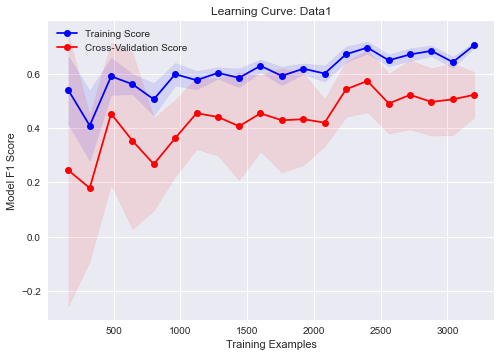

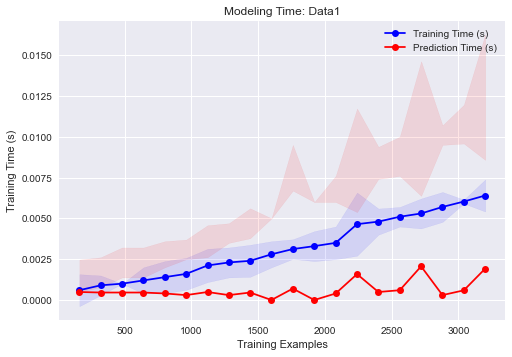

In [75]:
plot_learning_curve(knn_1, df_scaled['X1_train_s'].values, y1_train.values,
                    title = 'Data1');

#### Data 2

In [82]:
knn_2 = KNeighborsClassifier(n_neighbors = best_param_2['n_neighbors'], 
                             p = best_param_2['p'],
                            weights = best_param_2['weights'])

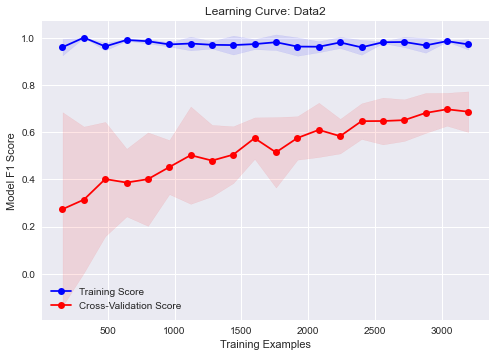

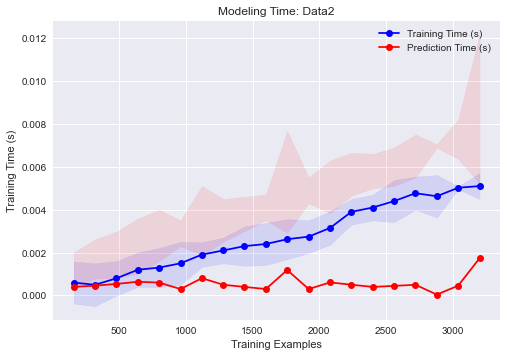

In [83]:
plot_learning_curve(knn_2, df_scaled['X2_train_s'].values, y2_train.values,
                    title = 'Data2');

### Model performance on the testing set

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00821
Model Prediction Time (s): 0.02776

F1 Score:  0.43
Accuracy:  0.80     AUC:       0.64
Precision: 0.49     Recall:    0.39
*****************************************************


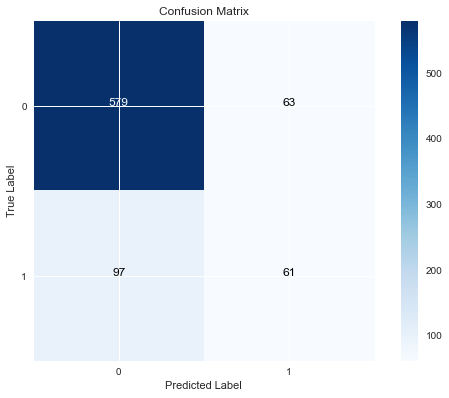

In [85]:
final_classifier_evaluation(knn_1,
                            df_scaled['X1_train_s'],
                            df_scaled['X1_test_s'],
                            y1_train,
                            y1_test)

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.00657
Model Prediction Time (s): 0.02577

F1 Score:  0.30
Accuracy:  0.68     AUC:       0.55
Precision: 0.29     Recall:    0.31
*****************************************************


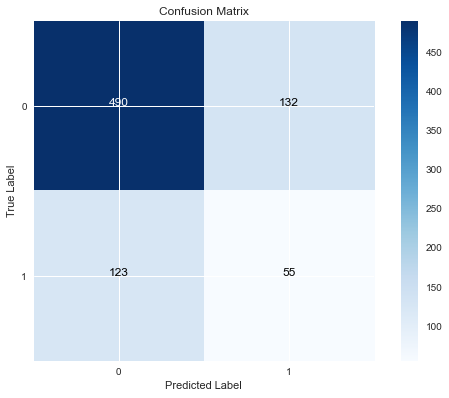

In [86]:
final_classifier_evaluation(knn_2,
                            df_scaled['X2_train_s'],
                            df_scaled['X2_test_s'],
                            y2_train,
                            y2_test)

## Algorithm 5: SVM

In [16]:
import seaborn as sns

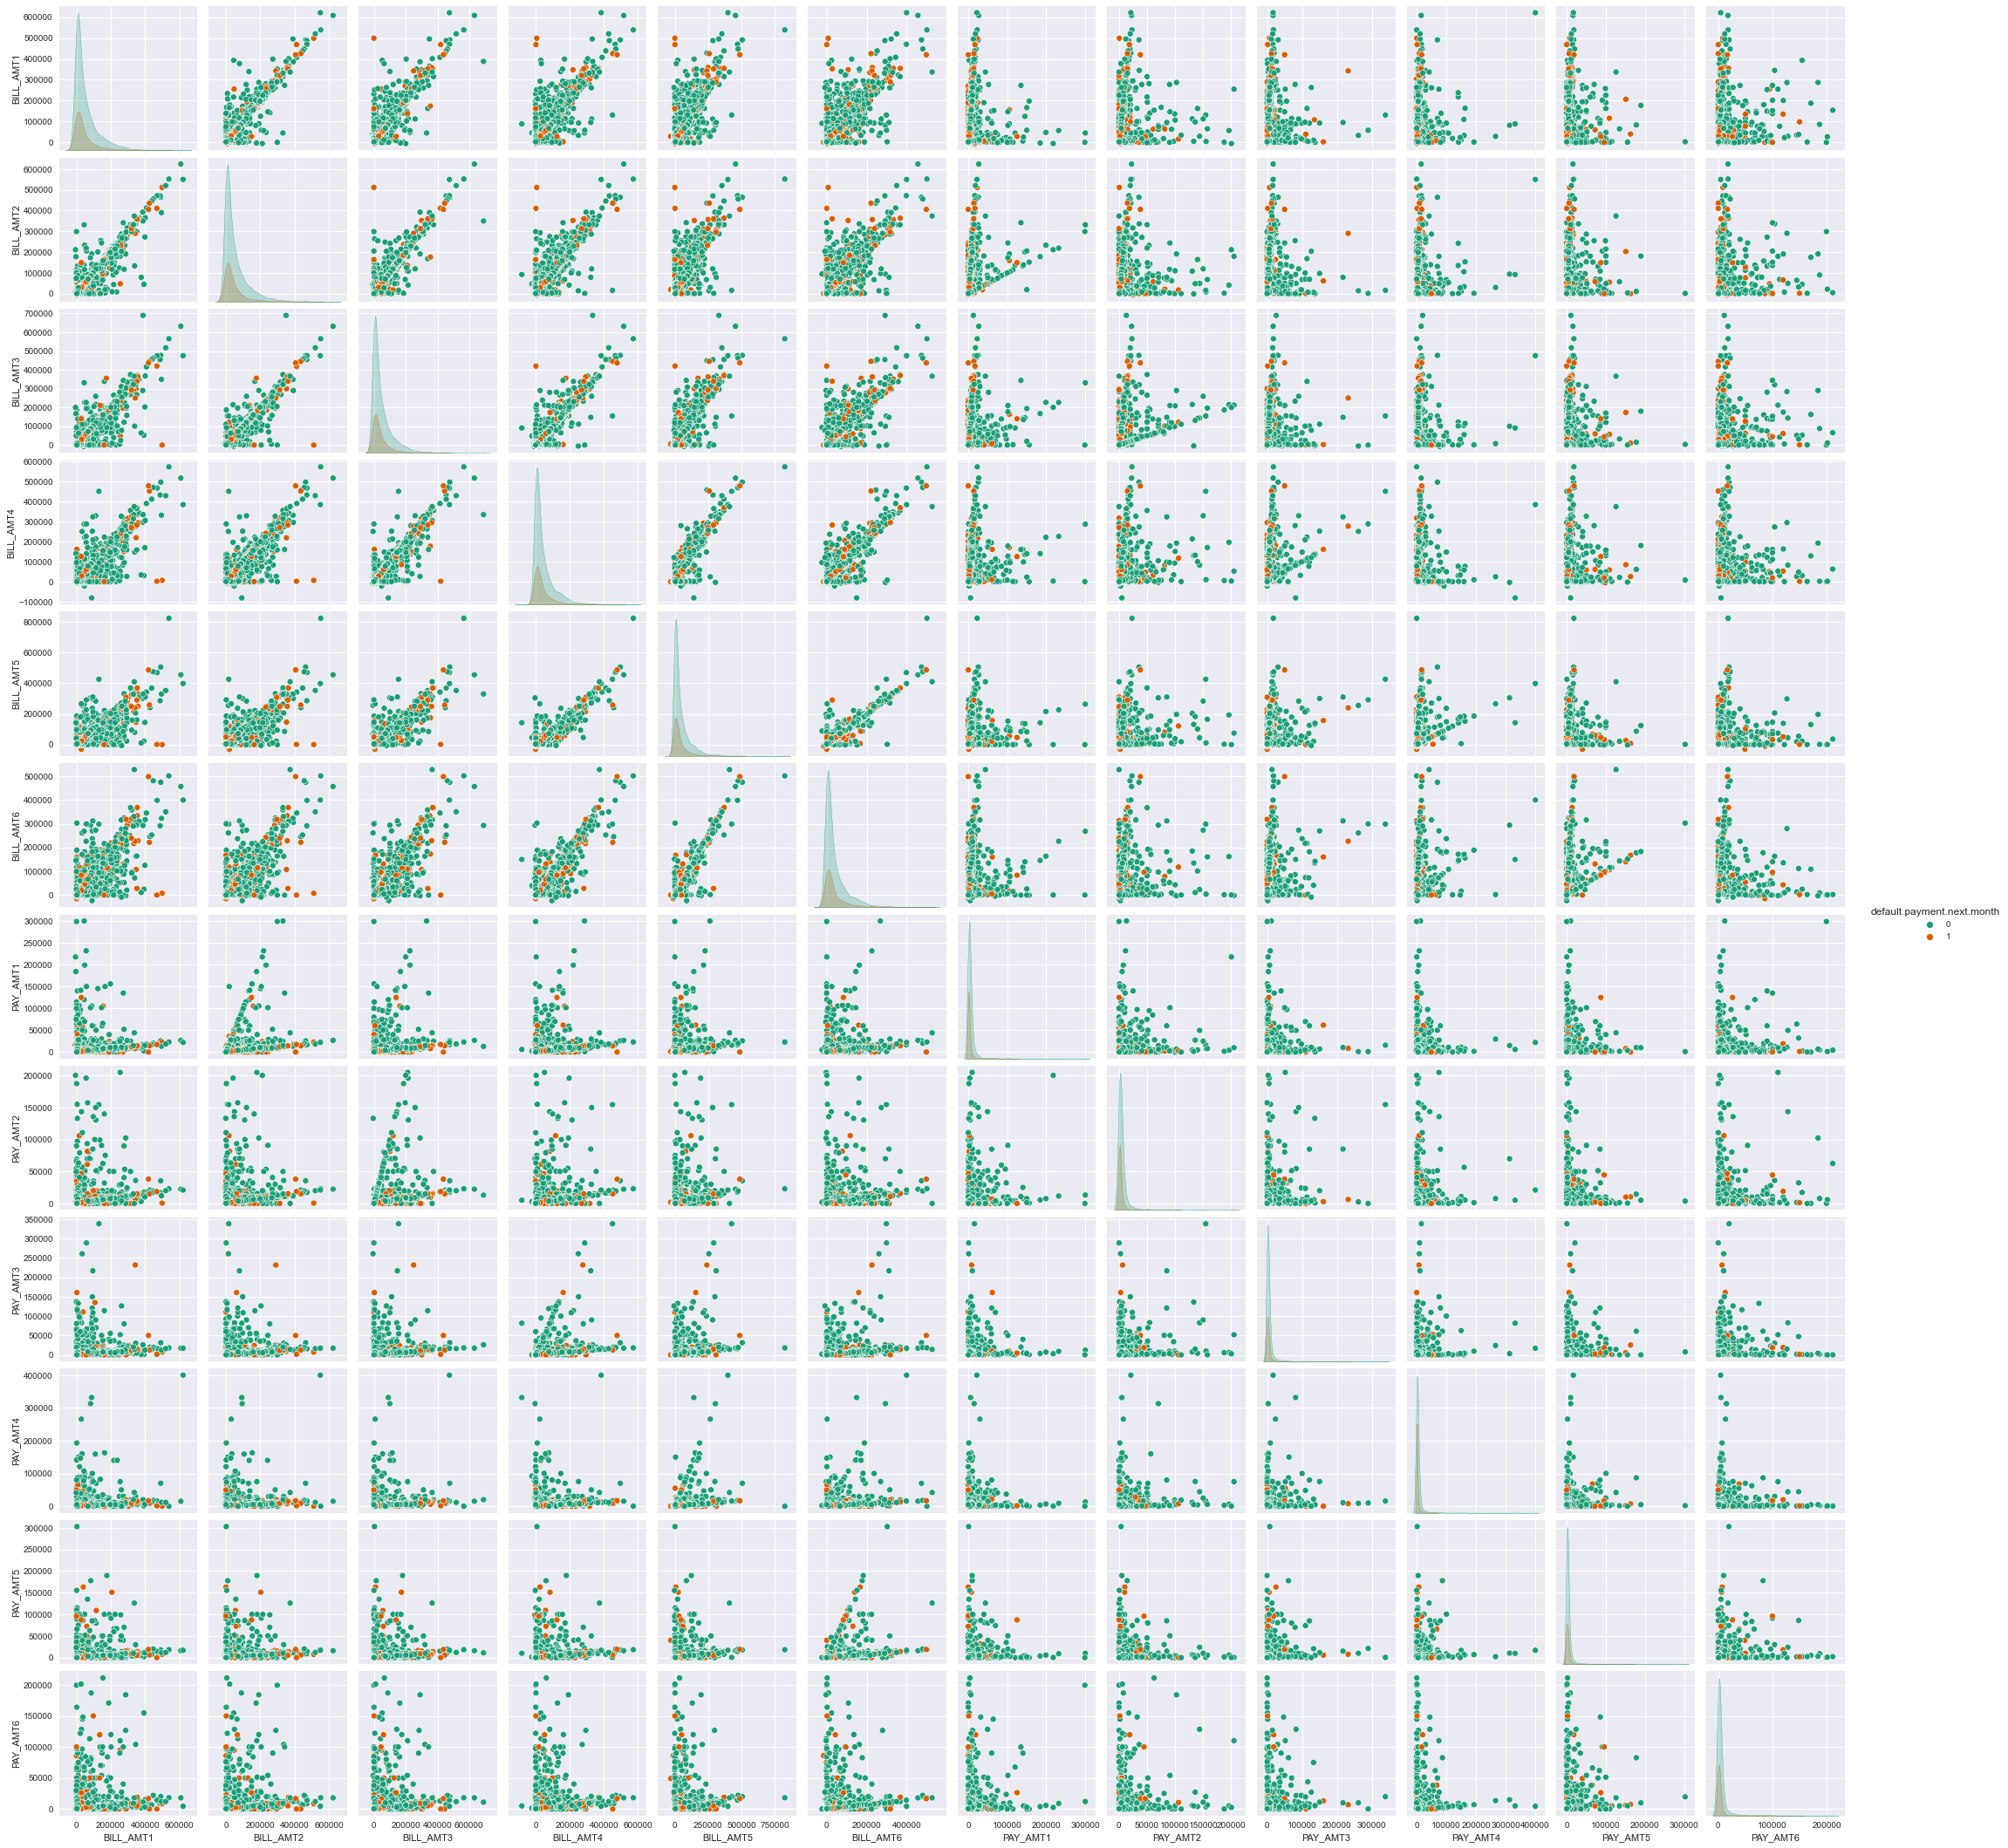

In [17]:
sns.pairplot(pd.concat([X2_train, y2_train], axis= 1), 
             hue = 'default.payment.next.month', palette = 'Dark2')

### Gridsearch

In [45]:
def SVMgridSearchCV(X_train, Y_train, X_test, Y_test,
                    param_grid = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                  'kernel' : ['linear','poly', 'rbf', 'sigmoid']}):
    
    params = list(itertools.product(param_grid['kernel'], param_grid['C']))

    results_dict = {}
    suffix = ['train', 'test']

    for kernel, C in params:
        svc_model = SVC(kernel = kernel, C = C)
        svc_model.fit(X_train, Y_train)
        y_pred_train = svc_model.predict(X_train)
        y_pred_test = svc_model.predict(X_test)

        if kernel + '_train' in results_dict.keys():
            results_dict[kernel + '_train'].append(f1_score(Y_train, y_pred_train))
        else:
            results_dict[kernel + '_train'] = list()
            results_dict[kernel + '_train'].append(f1_score(Y_train, y_pred_train))

        if kernel + '_test' in results_dict.keys():
            results_dict[kernel + '_test'].append(f1_score(Y_test, y_pred_test))
        else:
            results_dict[kernel + '_test'] = list()
            results_dict[kernel + '_test'].append(f1_score(Y_test, y_pred_test))    
        
    return results_dict

def SVMPlot(results_dict,  title, save_name, param_grid = {'C' : [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                                                        'kernel' : ['linear','poly', 'rbf', 'sigmoid']}):
    
    color_schema = list(zip(param_grid['kernel'], ['#E56997', '#BD97CB', '#FBC740', '#66D2D6']))

    for i in color_schema:
        plt.semilogx(param_grid['C'], results_dict[i[0] + '_train'], linestyle = '--', marker = 'o',
                 color = i[-1], label = f'Train F1 Score: {i[0]}')
        plt.semilogx(param_grid['C'], results_dict[i[0] + '_test'], linestyle = '-', marker = 'o',
                 color = i[-1], label = f'Test F1 Score: {i[0]}')

    plt.ylabel('Model F1 Score')
    plt.xlabel('Regularization parameter: C')

    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig(save_name)
    plt.show()
            
def finalGridSearch(X_train, Y_train): 
    import multiprocessing

    cores = multiprocessing.cpu_count()
    
    param_grid = {'C' : [0.01, 0.1, 1, 10],
                'kernel' : ['linear','poly', 'rbf', 'sigmoid']}
    
    svc_model = GridSearchCV(estimator = SVC(),
                      param_grid = param_grid, cv = 10, refit = True,
                      scoring = 'f1', n_jobs = cores - 1)
    svc_model.fit(X_train, Y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(svc_model.best_params_)
    print(svc_model.best_score_)
    return svc_model.best_params_

In [36]:
# data 1
results = SVMgridSearchCV(df_scaled['X1_train_s'], y1_train, df_scaled['X1_test_s'], y1_test)

In [87]:
best_param_1 = finalGridSearch(df_scaled['X1_train_s'], y1_train)

Per Hyperparameter tuning, best parameters are:
{'C': 10, 'kernel': 'rbf'}
0.4454219812886615


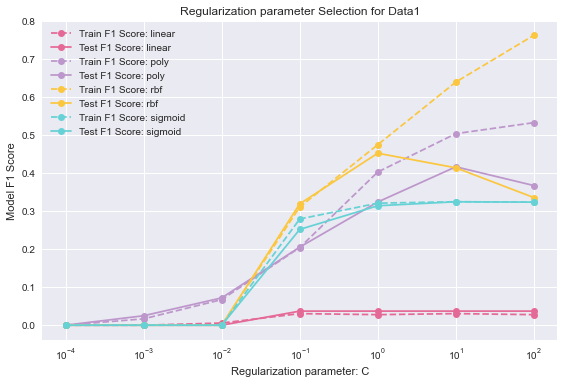

In [37]:
SVMPlot(results, title = 'Regularization parameter Selection for Data1', 
        save_name = 'd1_c_value_selection.png')

In [47]:
# data 2
results_2 = SVMgridSearchCV(df_scaled['X2_train_s'], y2_train, df_scaled['X2_test_s'], y2_test)

In [88]:
best_param_2 = finalGridSearch(df_scaled['X2_train_s'], y2_train)

Per Hyperparameter tuning, best parameters are:
{'C': 10, 'kernel': 'sigmoid'}
0.2695661228030136


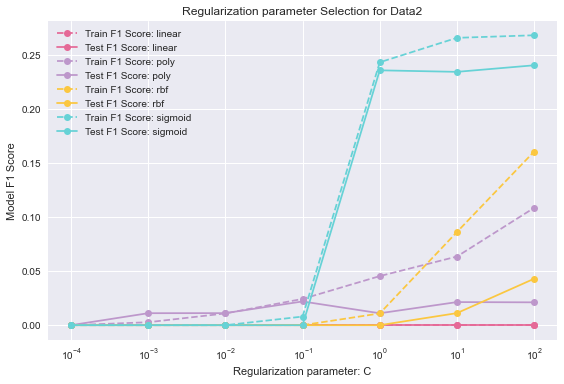

In [49]:
SVMPlot(results_2, title = 'Regularization parameter Selection for Data2', 
        save_name = 'd2_c_value_selection.png')

### Retrain with the output from Grid Search for two datasets

#### 1.1 Data 1 (best param)

{'C': 10, 'kernel': 'rbf'}

In [97]:
svc_model_1_1 = SVC(C = best_param_1['C'], kernel = best_param_1['kernel'])

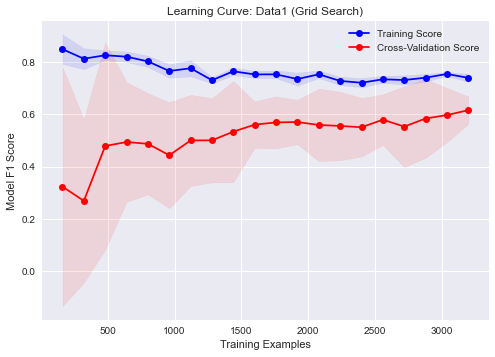

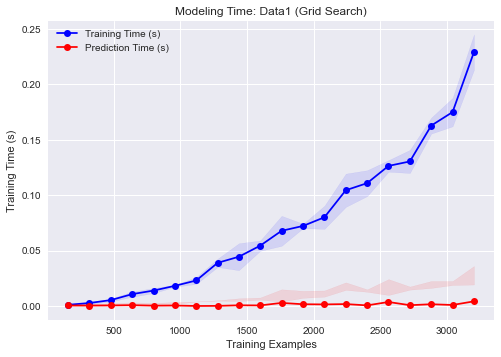

In [98]:
plot_learning_curve(svc_model_1_1, df_scaled['X1_train_s'].values, y1_train.values,
                    title = 'Data1 (Grid Search)');

#### 1.2 Data 1 (manually selected)

{'C': 1, 'kernel': 'sigmoid'}

In [57]:
m_param_1 = {'C': 1, 'kernel': 'sigmoid'}

In [67]:
svc_model_1_2 = SVC(C = m_param_1['C'], kernel = m_param_1['kernel'])

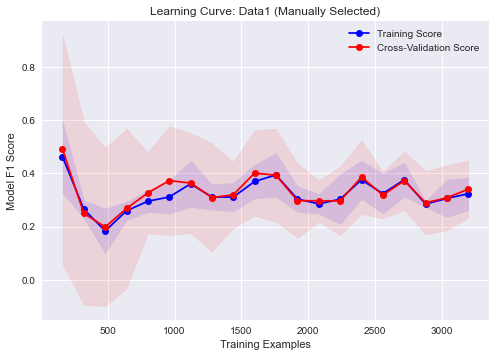

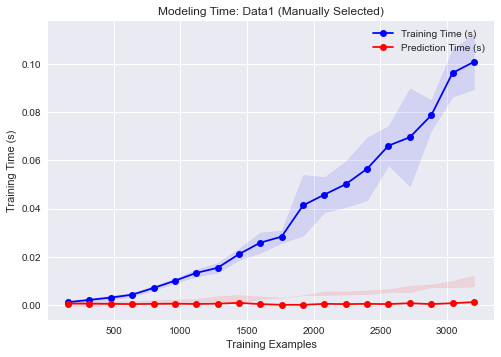

In [90]:
plot_learning_curve(svc_model_1_2, df_scaled['X1_train_s'].values, y1_train.values,
                    title = 'Data1 (Manually Selected)');

#### 2.1 Data 2 (Grid Search)

{'C': 10, 'kernel': 'sigmoid'}

In [69]:
svc_model_2_1 = SVC(C = best_param_2['C'], kernel = best_param_2['kernel'])

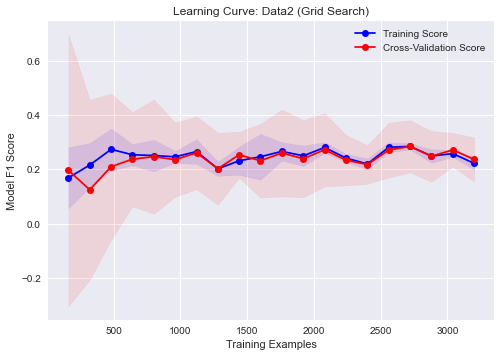

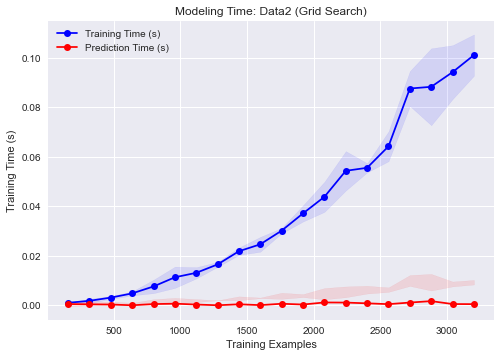

In [91]:
plot_learning_curve(svc_model_2_1, df_scaled['X2_train_s'].values, y2_train.values,
                    title = 'Data2 (Grid Search)');

#### 2.2 Data 2 (manually selected)

{'C': 10, 'kernel': 'poly'}

In [63]:
m_param_2 = {'C': 10, 'kernel': 'poly'}

In [71]:
svc_model_2_2 = SVC(C = m_param_2['C'], kernel = m_param_2['kernel'])

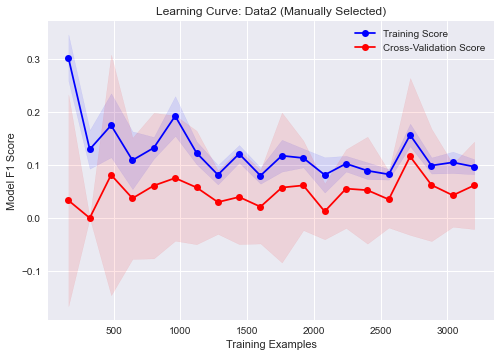

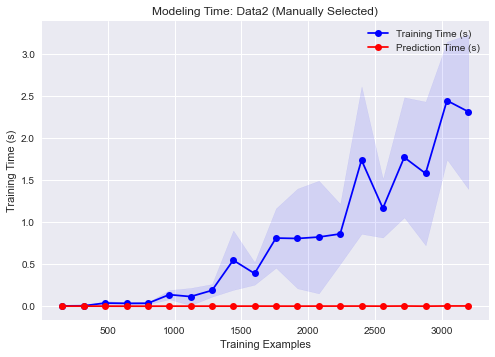

In [92]:
plot_learning_curve(svc_model_2_2, df_scaled['X2_train_s'].values, y2_train.values,
                    title = 'Data2 (Manually Selected)');

### Model performance on the testing set

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.25876
Model Prediction Time (s): 0.06190

F1 Score:  0.41
Accuracy:  0.81     AUC:       0.63
Precision: 0.54     Recall:    0.34
*****************************************************


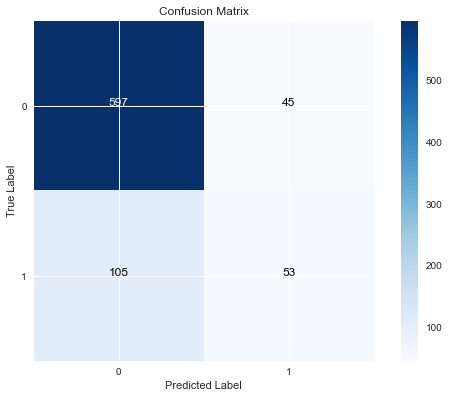

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.11210
Model Prediction Time (s): 0.02260

F1 Score:  0.31
Accuracy:  0.72     AUC:       0.57
Precision: 0.30     Recall:    0.33
*****************************************************


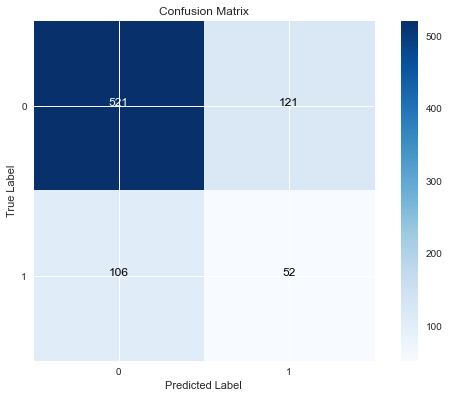

In [99]:
for i in [svc_model_1_1, svc_model_1_2]:
    final_classifier_evaluation(i, df_scaled['X1_train_s'], df_scaled['X1_test_s'], y1_train, y1_test)

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   0.11732
Model Prediction Time (s): 0.02250

F1 Score:  0.23
Accuracy:  0.67     AUC:       0.51
Precision: 0.25     Recall:    0.22
*****************************************************


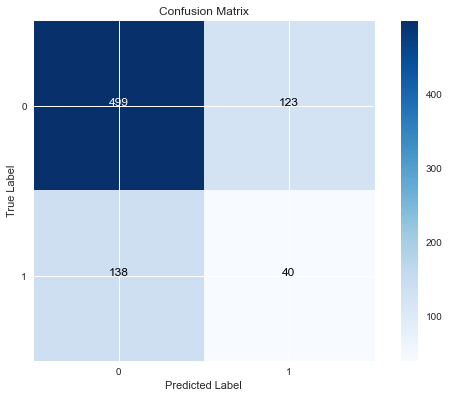

Model Evaluation Metrics Using Untouched Test Dataset
*****************************************************
Model Training Time (s):   3.91748
Model Prediction Time (s): 0.02295

F1 Score:  0.02
Accuracy:  0.77     AUC:       0.50
Precision: 0.22     Recall:    0.01
*****************************************************


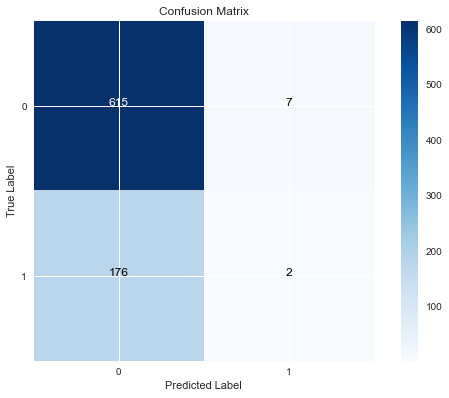

In [96]:
for i in [svc_model_2_1, svc_model_2_2]:
    final_classifier_evaluation(i, df_scaled['X2_train_s'], df_scaled['X2_test_s'], y2_train, y2_test)